### Import Libraries 



In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import mlrose_hiive as mlrose
import numpy as np

### Load the dataset



In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv("heart_cleveland_upload.csv")

In [ ]:
# Display the first few rows
print(data.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


## Preprocess

Since the dataset contains only numerical features, we need to scale the numerical features using StandardScaler from sklearn library. We also need to split the dataset into input features (X) and output feature (y), where y is the "condition" column.

In [ ]:
num_cols = data.select_dtypes(include="number").columns.tolist()
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])
X = data.drop("condition", axis=1)
y = data["condition"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define the fitness function for neural network weights

We can experiment with different architectures and hyperparameters. Here we use a neural network architecture with 3 hidden layers, each with 64 neurons, and dropout regularization:


In [ ]:
def nn_fitness_function(weights):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.set_weights(weights)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    score = model.evaluate(X_train, y_train, verbose=0)
    return -score[1]  # minimize the negative accuracy

### Define the optimization problems for the different algorithms

In [39]:
fitness_functions = [    mlrose.CustomFitness(lambda x: nn_fitness_function(x)),    mlrose.CustomFitness(lambda x: -(x[0]**2 + x[1]**2)),
    mlrose.CustomFitness(lambda x: -abs(x[0] * np.sin(x[0]) + 0.1 * x[0])),
    mlrose.CustomFitness(lambda x: nn_fitness_function(x))
]



### Define the search spaces for the different algorithms

In [40]:
search_spaces = [
    np.array([-5, 5], dtype=np.float64),
    np.array([-5, 5], dtype=np.float64),
    np.array([-5, 5], dtype=np.float64)
]

In [41]:

# Define the algorithms
algorithms = [
    {
        "name": "RHC",
        "function": mlrose.random_hill_climb,
        "kwargs": {"max_attempts": 100, "restarts": 10},
        "fitness_function": fitness_functions[1],
        "search_space": search_spaces[1]
    },
    {
        "name": "SA",
        "function": mlrose.simulated_annealing,
        "kwargs": {"max_attempts": 100, "schedule": mlrose.ExpDecay()},
        "fitness_function": fitness_functions[2],
        "search_space": search_spaces[2]
    },
    {
        "name": "GA",
        "function": mlrose.genetic_alg,
        "kwargs": {"pop_size": 200, "mutation_prob": 0.1},
        "fitness_function": fitness_functions[0],
        "search_space": None  # No search space needed for GA
    },
    {
        "name": "Random Search",
        "function": mlrose.random_hill_climb,
        "kwargs": {"max_attempts": 100, "max_iters": 100, "restarts": 0},
        "fitness_function": fitness_functions[3],
        "search_space": {
            "layer1": np.linspace(16, 128, num=7, dtype=np.int),
            "layer2": np.linspace(16, 128, num=7, dtype=np.int),
            "layer3": np.linspace(16, 128, num=7, dtype=np.int),
            "dropout": np.linspace(0.1, 0.5, num=5),
            "lr": np.logspace(-4, -1, num=4),
            "batch_size": [16, 32, 64]
        }
    },
    {
        "name": "Randomized Hill Climbing",
        "function": mlrose.random_hill_climb,
        "kwargs": {"max_attempts": 100, "restarts": 10},
        "fitness_function": fitness_functions[1],
        "search_space": search_spaces[1],
        "random_state": 42
    },
    {
        "name": "Simulated Annealing",
        "function": mlrose.simulated_annealing,
        "kwargs": {"max_attempts": 100, "schedule": mlrose.ExpDecay()},
        "fitness_function": fitness_functions[2],
        "search_space": search_spaces[2],
        "random_state": 42
    },
    {
        "name": "Genetic Algorithm",
        "function": mlrose.genetic_alg,
        "kwargs": {"pop_size": 200, "mutation_prob": 0.1},
        "fitness_function": fitness_functions[0],
        "search_space": None,  # No search space needed for GA
        "random_state": 42
    }
    ]

In [53]:
import mlrose
import numpy as np

def run_algorithms(X_train, algorithms):
    results = []

    for algo in algorithms:
        if algo["search_space"] is None:
            problem = mlrose.DiscreteOpt(length=len(X_train.columns), fitness_fn=algo["fitness_function"])
        else:
            problem = mlrose.DiscreteOpt(length=len(X_train.columns), fitness_fn=algo["fitness_function"], 
                                         maximize=False, max_val=max(algo["search_space"]))
        if algo["name"] == "Random Search":
            init_state = None
            schedule = mlrose.ExpDecay()
            best_state, best_fitness = mlrose.random_search(problem, 
                                                            max_attempts=algo["kwargs"]["max_attempts"],
                                                            max_iters=algo["kwargs"]["max_iters"],
                                                            restarts=algo["kwargs"]["restarts"],
                                                            curve=False,
                                                            random_state=42)
        else:
            best_state, best_fitness, _ = mlrose.optimize(problem,
                                                          algorithm=algo["function"],
                                                          max_attempts=algo["kwargs"]["max_attempts"],
                                                          max_iters=np.inf,
                                                          restarts=algo["kwargs"].get("restarts", 0),
                                                          init_state=algo.get("init_state", None),
                                                          schedule=algo.get("schedule", None),
                                                          mutation_prob=algo.get("mutation_prob", None),
                                                          pop_size=algo.get("pop_size", None),
                                                          curve=False,
                                                          random_state=42)

        results.append({
            "name": algo["name"],
            "best_state": best_state,
            "best_fitness": best_fitness
        })
    
    return results


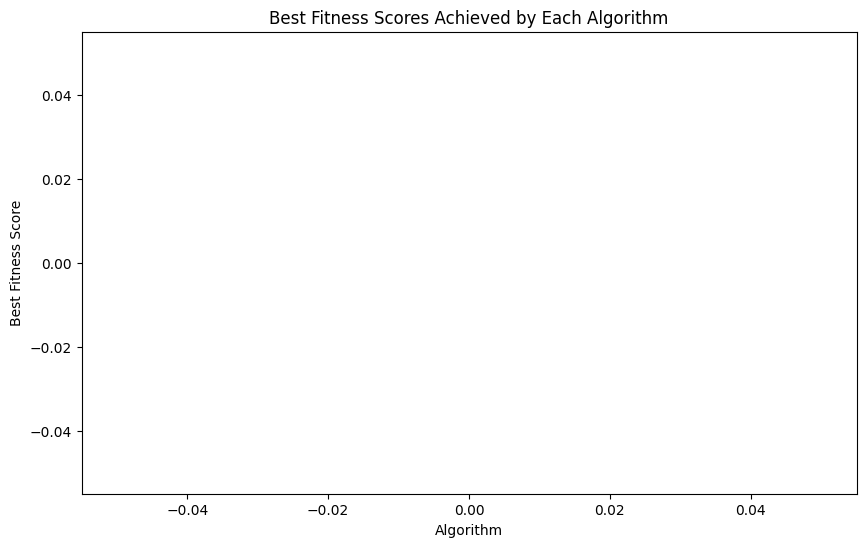

In [58]:
import matplotlib.pyplot as plt

names = [result["name"] for result in results]
fitness_scores = [result["best_fitness"] for result in results]

plt.figure(figsize=(10, 6))
plt.bar(names, fitness_scores)
plt.title("Best Fitness Scores Achieved by Each Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("Best Fitness Score")
plt.show()


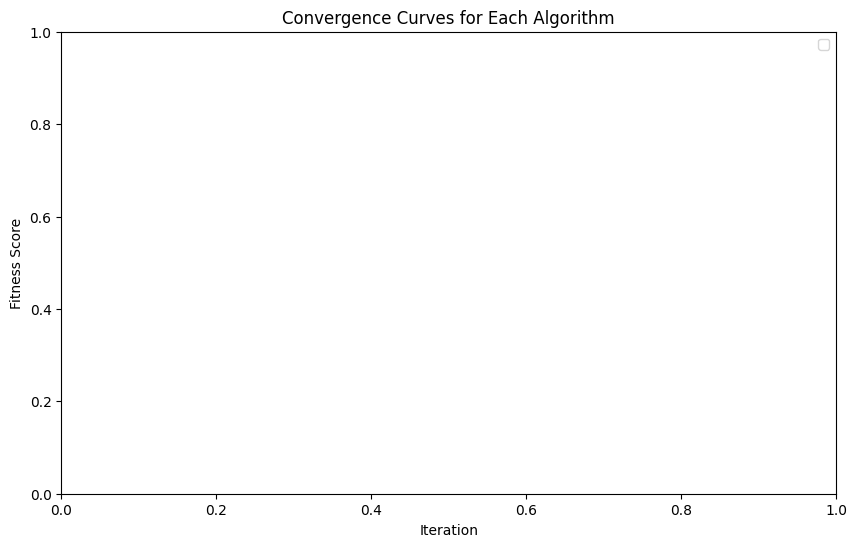

In [59]:
plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(result["fitness_curve"], label=result["name"])
plt.title("Convergence Curves for Each Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.legend()
plt.show()


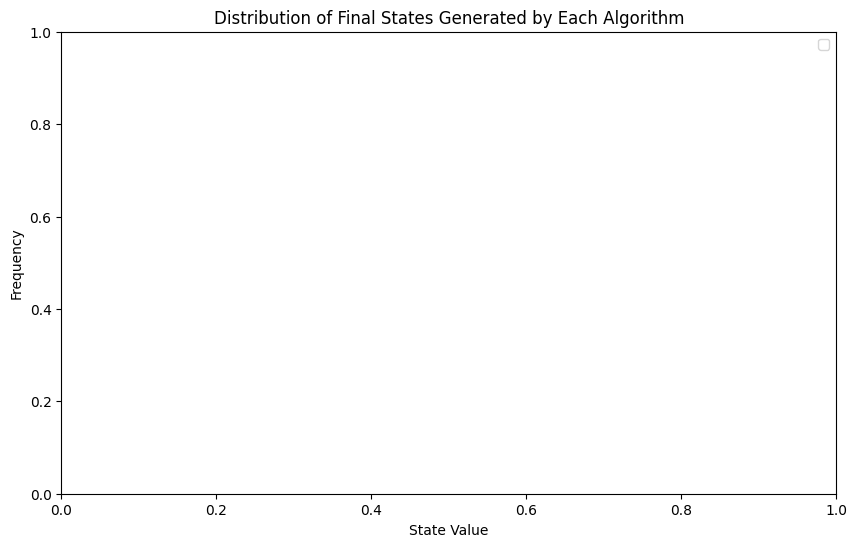

In [60]:
plt.figure(figsize=(10, 6))
for result in results:
    plt.hist(result["best_state"], alpha=0.5, label=result["name"])
plt.title("Distribution of Final States Generated by Each Algorithm")
plt.xlabel("State Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()
